### Look at the cross decodability of pseudo decoders

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"
# path to a dataframe of sessions to analyze
# SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions.pickle"
SESSIONS_PATH = "/data/patrick_res/multi_sess/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
SESS_SPIKES_PATH = "/data/patrick_res/multi_sess/{sess_name}/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_1_smooth.pickle"

DATA_MODE = "SpikeCounts"
TEST_RATIO = 0.2

FEATURE_DIMS = ["Color", "Shape", "Pattern"]

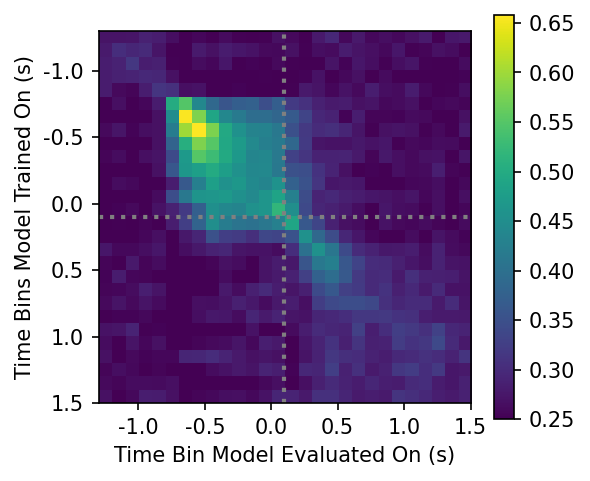

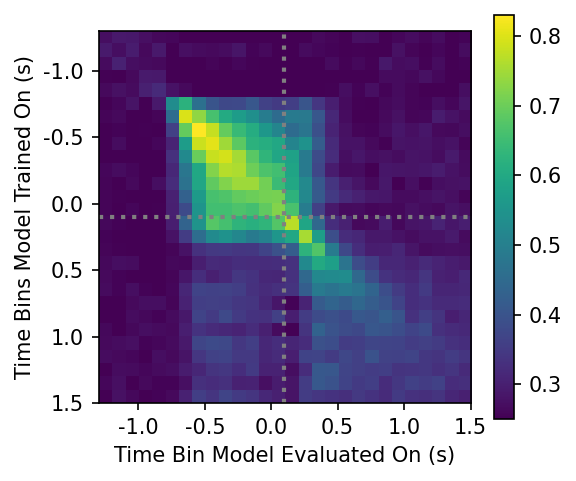

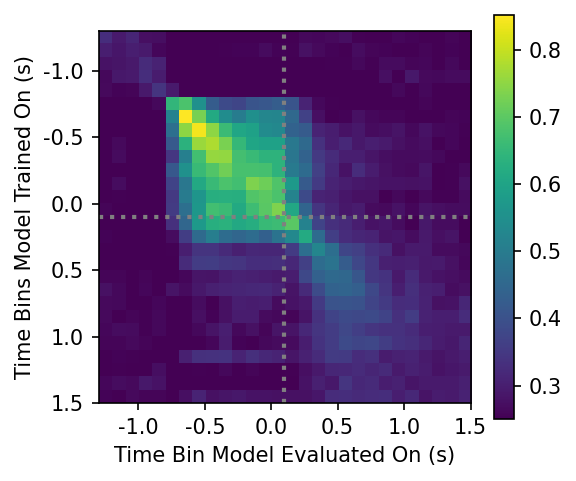

In [5]:
interval_size = 100

for feature_dim in FEATURE_DIMS: 
    cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_accs.npy"))
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150)
    colors = ax.matshow(cross_accs)
    fig.colorbar(colors)

    ratio = 1000 / interval_size
    tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    tick_pos = (tick_labels + 1.3) * ratio - 0.5

    colors.set_clim(vmin=0.25)

    # tick_labels = np.arange(len(cross_accs))
    # tick_pos = np.arange(len(cross_accs))
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel("Time Bin Model Evaluated On (s)")
    ax.set_ylabel("Time Bins Model Trained On (s)")
    # ax.set_title(f"{feature_dim} Decoders Mean Accuracies Across Timebins")
    ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=2)
    ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=2)

                    

### Look at basis of model weights
First make sure that weights between splits are relatively correlated

In [4]:
weights = []
for feature_dim in FEATURE_DIMS:
    model = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_models.npy"), allow_pickle=True)

In [5]:
model[6, 0].coef_.shape

(4, 756)

In [6]:
# weights_mat = np.empty((model.shape[0], model.shape[1], num_neurons, num_classes))
# populate
weights = []
for i, model_split in enumerate(model[6, :]):
    weights.append(model_split.coef_[0])

In [7]:
weights = np.vstack(weights)

In [8]:
weights.shape

(8, 756)

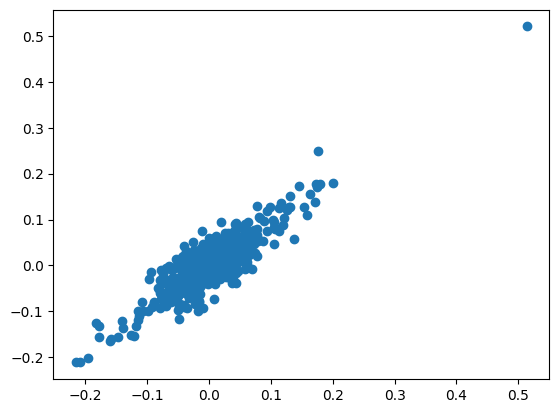

In [9]:
plt.scatter(weights[2], weights[3])

### Average out model weights to get 4 vectors per feature dimension

In [17]:
def get_orth_decoding_axes_for_time_bin(time_bin_idx):
    weights_across_dims = []
    for feature_dim in FEATURE_DIMS:
        model = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_models.npy"), allow_pickle=True)
        weights = []
        for i, model_split in enumerate(model[time_bin_idx, :]):
            weights.append(model_split.coef_.T)
        mean_across_splits = np.mean(weights, axis=0)
        weights_across_dims.append(mean_across_splits)
    axes = np.hstack(weights_across_dims)
    orth_axes = scipy.linalg.orth(axes)
    return orth_axes

def get_orth_decoding_axes_for_time_bins(time_bin_idxs):
    weights_across_dims = []
    for feature_dim in FEATURE_DIMS:
        model = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_models.npy"), allow_pickle=True)
        for time_idx in time_bin_idxs:
            weights = []
            for i, model_split in enumerate(model[time_idx, :]):
                weights.append(model_split.coef_.T)
            mean_across_splits = np.mean(weights, axis=0)
            weights_across_dims.append(mean_across_splits)
    axes = np.hstack(weights_across_dims)
    orth_axes = scipy.linalg.orth(axes)
    return orth_axes

In [13]:
orth_axes_choice = get_orth_decoding_axes_for_time_bin(6)
orth_axes_fb = get_orth_decoding_axes_for_time_bin(18)

In [19]:
orth_axes_many_choice = get_orth_decoding_axes_for_time_bins(np.arange(5, 13))
orth_axes_many_fb = get_orth_decoding_axes_for_time_bins(np.arange(14, 22))

In [22]:
np.save("/data/patrick_res/orth_axes_many_choice.npy", orth_axes_choice)
np.save("/data/patrick_res/orth_axes_many_fb.npy", orth_axes_fb)

In [16]:
np.save("/data/patrick_res/orth_axes_choice.npy", orth_axes_choice)
np.save("/data/patrick_res/orth_axes_fb_18.npy", orth_axes_fb)


In [13]:
orth_axes_fb.shape

(754, 12)

### Get PSTHs of RPE group + Color, Shape, Pattern

In [12]:
sessions = pd.read_pickle(SESSIONS_PATH)

In [35]:
def calc_psth_per_session(row, conditions):
    sess_name = row.session_name
    beh, frs = io_utils.load_rpe_sess_beh_and_frs(sess_name)
    if frs.SpikeCounts.isnull().values.any():
        print("null valuessssss")
    mode = "SpikeCounts"
    def zscore_unit(group):
        mean = group[mode].mean()
        std = group[mode].std()
        group[f"Z{mode}"] = 0 if std == 0 else (group[mode] - mean) / std
        return group
    frs = frs.groupby(["UnitID", "TimeBins"]).apply(zscore_unit)
    if frs.ZSpikeCounts.isnull().values.any():
        raise ValueError("Why are there null values after zscoring")
    merged = pd.merge(beh[conditions], frs, on="TrialNumber")
    group_conds = conditions + ["UnitID", "TimeBins"]
    psth = merged.groupby(group_conds).mean()["ZSpikeCounts"].reset_index()
    psth["PseudoUnitID"] = int(sess_name) * 100 + psth["UnitID"]
    return psth

In [ ]:
dim_psths = []
for feature_dim in FEATURE_DIMS:
    conditions = ["RPEGroup", feature_dim]
    dim_psth = pd.concat(sessions.apply(lambda x: calc_psth_per_session(x, conditions), axis=1).values)
    dim_psth = dim_psth.rename(columns={feature_dim: "Feature"})
    dim_psths.append(dim_psth)
full_psth = pd.concat(dim_psths)

In [37]:
full_psth.to_pickle("/data/patrick_res/rpe_features_psth.pickle")

### Project full psth into subspaces

In [99]:
full_psth = pd.read_pickle("/data/patrick_res/rpe_features_psth.pickle")

In [100]:
def sort_points(group):
    sorted = group.sort_values(by="PseudoUnitID").ZSpikeCounts.values
    return sorted
projection = orth_axes_fb.T
psth_list = full_psth.groupby(["RPEGroup", "Feature", "TimeBins"]).apply(sort_points).reset_index()

In [101]:
psth_list["Response"] = "Correct"
psth_list.loc[psth_list.RPEGroup.isin(["less neg", "more neg"]), "Response"] = "Incorrect"

In [102]:
fb_projection = orth_axes_fb.T
choice_projection = orth_axes_choice.T

In [103]:
data = np.vstack(psth_list[0].values).T

In [104]:
fb_data_proj = (fb_projection @ data).T
choice_data_proj = (choice_projection @ data).T

In [105]:
labels = psth_list.Response.values

### Fit logsitic regressor to RPE group

In [124]:
data_train, data_test, label_train, label_test = train_test_split(choice_data_proj, labels, test_size=0.2)

In [125]:
clf = LogisticRegression(multi_class="multinomial")
clf = clf.fit(data_train, label_train)
clf.score(data_test, label_test)

0.79182156133829